## 클러스터링 진행

<mark>k-means</mark>

- 사용한 컬럼 

    1. Area z: <br>
    z-axis LHEE , RHEE 넓이 차<br>
    
    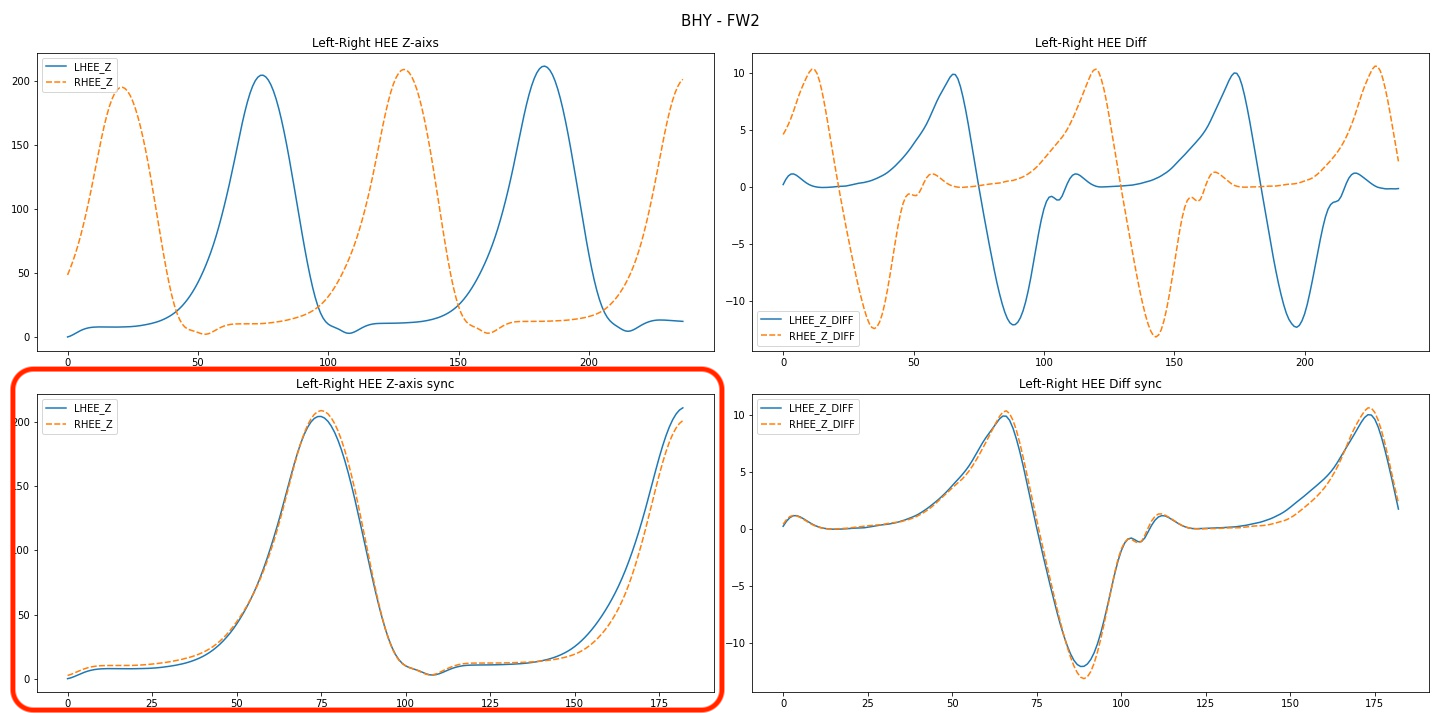
    2. Area-z-diff:<br>
    기울이 LHEE, RHEE 널이 차<br>
    
    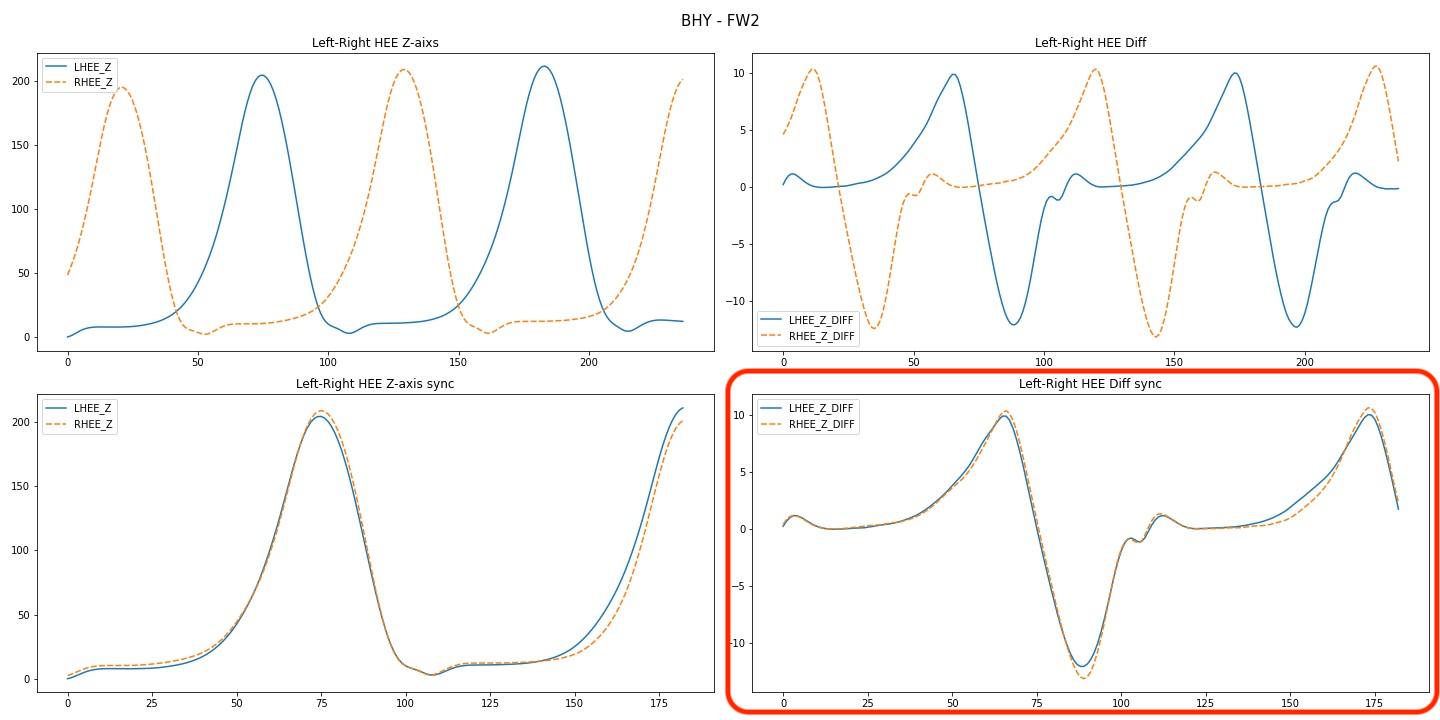
    3. Steps:<br>
    HEE 최대 수<br>
    
    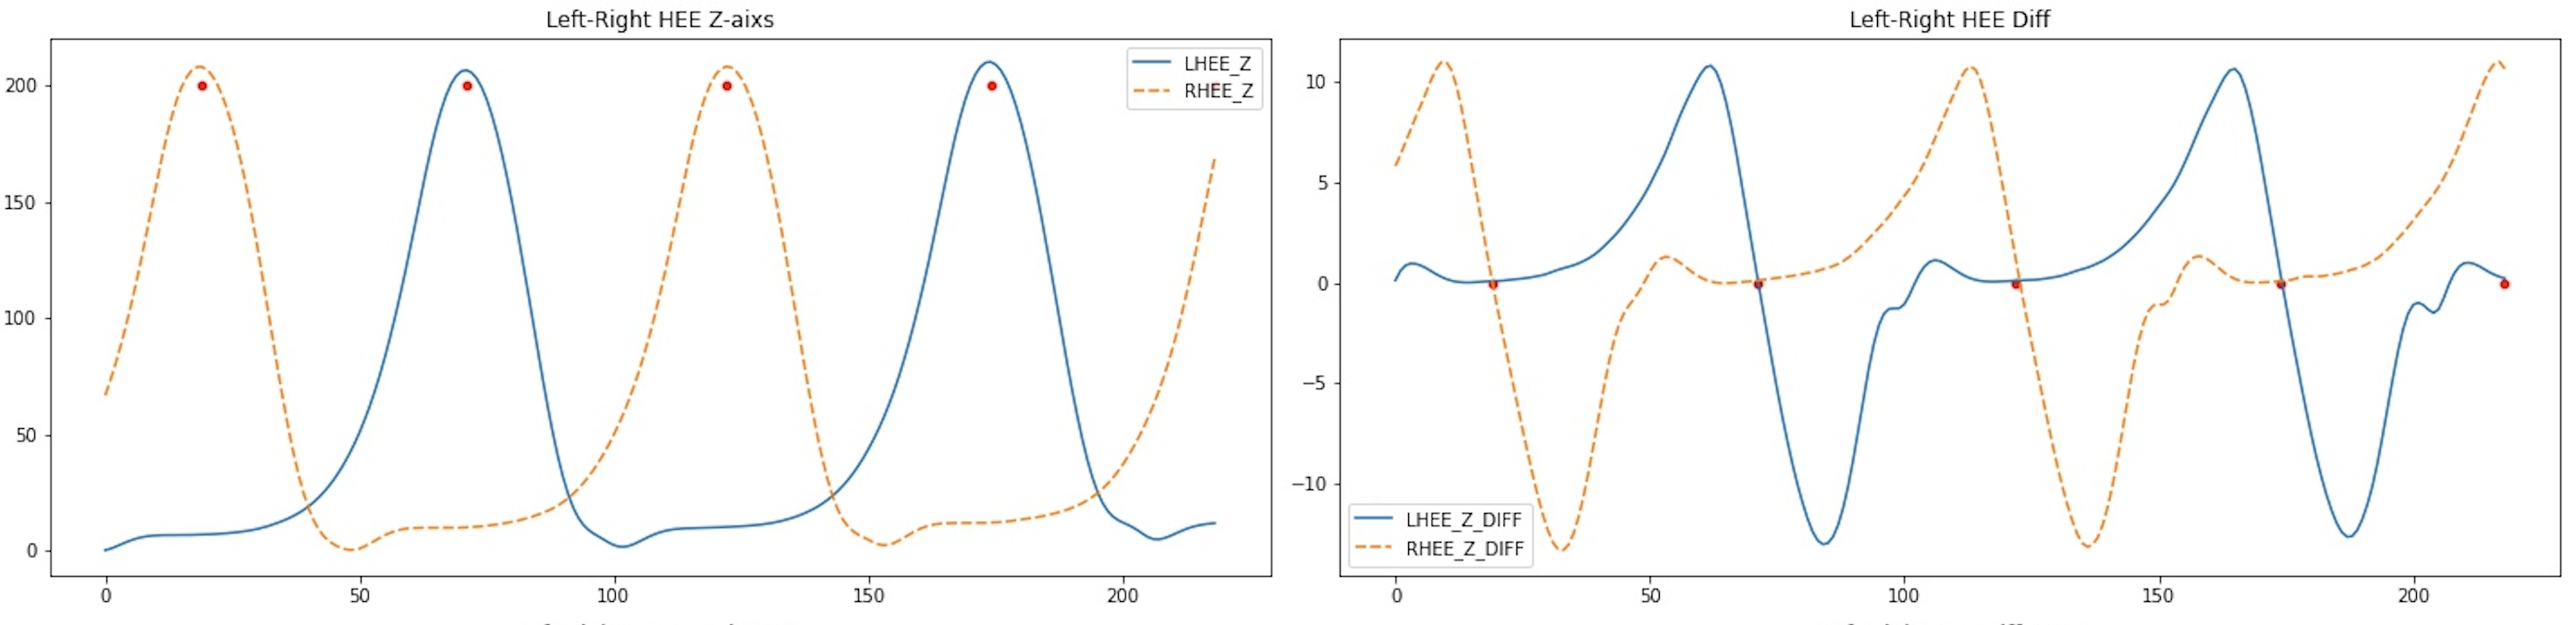
    

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [2]:
from utils.datatools import * # getPatientsTable()

In [3]:
PHASEPATH = "/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE/"
STDPATH = "/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/"
CONTROL_PATH = os.path.join(STDPATH, "Controls")
PD_PATH = os.path.join(STDPATH, "PD")
STDVIZPATH = "/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD_viz/"
VIZ_CONTROL_PATH = os.path.join(STDVIZPATH, "Controls")
VIZ_PD_PATH = os.path.join(STDVIZPATH, "PD")

In [4]:
# 사용 가능한 컬럼 
# 1. 면적
# 2. 걷는 회수
# 3. z 최대-최소
# 4. 각 페이즈별 프레임 수의 차이

df = pd.DataFrame(columns=["Patient", "Area-z", "Area-z-diff", "Steps", "Z-diff", "Phase1-diff", "Category"])

In [5]:
patients = getPatientsTable()
CONTROL = patients[patients["Category"] == "Controls"]
PD = patients[patients["Category"] == "PD"]

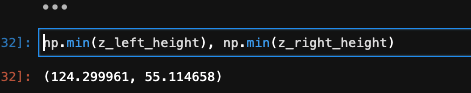

In [6]:
for pName, pCate in patients[["Patient", "Category"]].values:
    print(pName, pCate)
#     print(glob.glob(os.path.join(CONTROL_PATH, f"*{pName}*")))
#     print(glob.glob(os.path.join(VIZ_CONTROL_PATH, f"*{pName}*AREA.npy")))
    
    # 1. area
    
    TARGET_VIZ_PATH = VIZ_CONTROL_PATH
    if pCate == "PD": TARGET_VIZ_PATH = VIZ_PD_PATH
    
    area_z = []
    area_z_diff = []
    vizfileList = sorted(glob.glob(os.path.join(TARGET_VIZ_PATH, f"*{pName}*AREA.npy")))
    for file in vizfileList:
        # [ LH, RH, LH_DIFF, RH_DIFF ]
        LH, RH, LH_DIFF, RH_DIFF = np.load(file)
        area_z.append(LH - RH)
        area_z_diff.append(LH_DIFF - RH_DIFF)
        
    # 2. steps
    
    TARGET_PATH = CONTROL_PATH
    if pCate == "PD": TARGET_PATH = PD_PATH
    
    cnt_peeks = []
    
    z_diff = []
    fileList = sorted(glob.glob(os.path.join(TARGET_PATH, f"*{pName}*")))
    for file in fileList:
        print(file)
        cnt = 0

        data = pd.read_csv(file)
        WINDOW = 5
        
        TARGET_P = 1
        start = [np.where(data["PHASE"] == TARGET_P)[0][0]] + [ x for idx, x in enumerate(np.where(data["PHASE"] == TARGET_P)[0][:-1]) if np.where(data["PHASE"] == TARGET_P)[0][idx+1] - x > WINDOW ]
        n_left = len([ idx for idx in start if data.iloc[idx]["LHEE_Z"] > 50] )
        n_right = len([ idx for idx in start if data.iloc[idx]["RHEE_Z"] > 50])
        
#         print(start)
#         print(start_right)
        
        cnt += (n_left + n_right)
#         print(cnt, "|", n_left, "+", n_right)
        cnt_peeks.append(cnt)
        
        # 3. z-diff 
        
#         print(np.max(data["LHEE_Z"].values) - np.max(data["RHEE_Z"].values))
        z_diff.append((np.max(data["LHEE_Z"].values) - np.min(data["LHEE_Z"].values)) \
                      - (np.max(data["RHEE_Z"].values) - np.min(data["RHEE_Z"].values)))
        
        
    info = {"Patient": pName, 
            "Area-z": np.mean(np.array(area_z)), 
            "Area-z-diff": np.mean(np.array(area_z_diff)), 
            "Steps": np.mean(np.array(cnt_peeks)),
            "Z-diff": np.mean(np.array(z_diff)), 
#             "Phase1-diff",
            "Category": pCate}
    print(info)
    
    df = df.append(info, ignore_index=True)

BHY Controls
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_BHY_FW1.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_BHY_FW2.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_BHY_FW3.csv
{'Patient': 'BHY', 'Area-z': 102.709147999999, 'Area-z-diff': 17.002112, 'Steps': 4.666666666666667, 'Z-diff': 2.1686453333333304, 'Category': 'Controls'}
CHH Controls
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_CHH_FW1.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_CHH_FW2.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_CHH_FW3.csv
{'Patient': 'CHH', 'Area-z': 304.2274516666669, 'Area-z-diff': -1.6168286666666631, 'Steps': 4.333333333333333, 'Z-diff': 1.5347419999999943, 'Category': 'Controls'}
HSH Controls
/Users/suj

/Users/sujinlee/.virtualenvs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sujinlee/.virtualenvs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'Patient': 'SHI', 'Area-z': 510.90227800000076, 'Area-z-diff': -3.6631420000000094, 'Steps': 6.0, 'Z-diff': -16.106890333333325, 'Category': 'Controls'}
SeoBS Controls
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_SeoBS_FW1.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_SeoBS_FW2.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_SeoBS_FW3.csv
{'Patient': 'SeoBS', 'Area-z': 302.1755716666673, 'Area-z-diff': -40.27556366666668, 'Steps': 4.666666666666667, 'Z-diff': -10.938640333333325, 'Category': 'Controls'}
SeoJY Controls
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_SeoJY_FW1.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_SeoJY_FW2.csv
/Users/sujinlee/desktop/git_repositories/nims_pd/dataset_LHEE_RHEE_Z_PHASE_STD/Controls/LHEE_SeoJY_FW3.csv
{'Pati

In [8]:
df

,Patient,Area-z,Area-z-diff,Steps,Z-diff,Phase1-diff,Category
0,BHY,102.709148,17.002112,4.666667,2.168645,NaN,Controls
1,CHH,304.227452,-1.616829,4.333333,1.534742,NaN,Controls
2,HSH,986.371234,2.317568,7.000000,-5.447750,NaN,Controls
3,JHY,-321.453166,-1.757943,6.333333,-0.298990,NaN,Controls
4,JJG,1381.638530,9.256764,5.333333,2.860518,NaN,Controls
...,...,...,...,...,...,...,...
100,YJM,-1365.146321,0.854123,6.666667,-12.119766,NaN,PD
101,YKJ,-1122.525300,19.884308,7.333333,-18.428732,NaN,PD
102,YKS,-1287.355149,3.760910,5.000000,-0.866200,NaN,PD
103,YSC,NaN,NaN,NaN,NaN,NaN,PD


In [9]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
             [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [64]:
targetIdxs = [1,2,3]
targetColumns = df.columns[targetIdxs].values
print("컬럼 종류:", targetColumns)

컬럼 종류: ['Area-z' 'Area-z-diff' 'Steps']


In [65]:
pIdx = df.iloc[:,targetIdxs].dropna().index

In [66]:
X = df.iloc[:,targetIdxs].dropna().values
Y = [ 0 if df["Category"][idx] == "Controls" else 1 for idx in pIdx ]

model = KMeans(n_clusters = 2).fit(X)

y_hat = model.predict(X)

print("Average silhouette_score :", silhouette_score(X, y_hat))

Average silhouette_score : 0.5423842093487247


Text(0, 0.5, 'Area-z-diff')

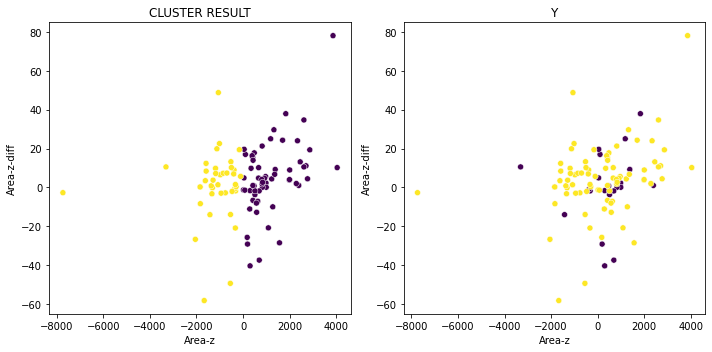

In [70]:
tc1 = 0
tc2 = 1

x = X[:, tc1]
y = X[:, tc2]

fig, axes = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
# fig.suptitle(f"{patient} - FW1", fontsize=15)

sns.scatterplot(ax=axes[0], x=x, y=y, c=y_hat)
axes[0].set_title("CLUSTER RESULT")
axes[0].set_xlabel(targetColumns[tc1])
axes[0].set_ylabel(targetColumns[tc2])

sns.scatterplot(ax=axes[1], x=x, y=y, c=Y)
axes[1].set_title("Y")
axes[1].set_xlabel(targetColumns[tc1])
axes[1].set_ylabel(targetColumns[tc2])

Text(0, 0.5, 'Steps')

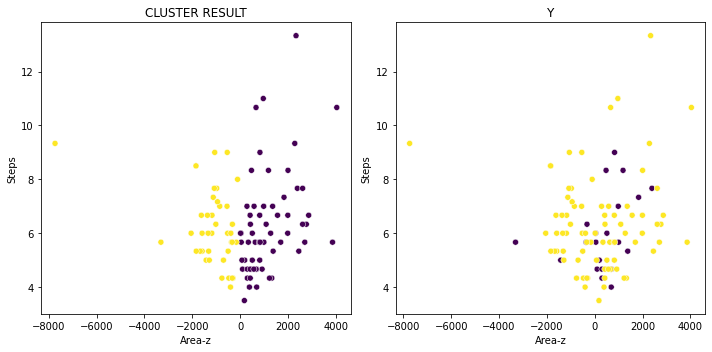

In [71]:
tc1 = 0
tc2 = 2

x = X[:, tc1]
y = X[:, tc2]

fig, axes = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
# fig.suptitle(f"{patient} - FW1", fontsize=15)

sns.scatterplot(ax=axes[0], x=x, y=y, c=y_hat)
axes[0].set_title("CLUSTER RESULT")
axes[0].set_xlabel(targetColumns[tc1])
axes[0].set_ylabel(targetColumns[tc2])

sns.scatterplot(ax=axes[1], x=x, y=y, c=Y)
axes[1].set_title("Y")
axes[1].set_xlabel(targetColumns[tc1])
axes[1].set_ylabel(targetColumns[tc2])

Text(0, 0.5, 'Steps')

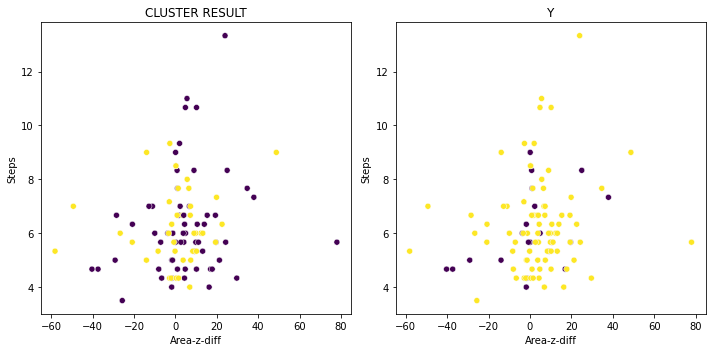

In [72]:
tc1 = 1
tc2 = 2

x = X[:, tc1]
y = X[:, tc2]

fig, axes = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
# fig.suptitle(f"{patient} - FW1", fontsize=15)

sns.scatterplot(ax=axes[0], x=x, y=y, c=y_hat)
axes[0].set_title("CLUSTER RESULT")
axes[0].set_xlabel(targetColumns[tc1])
axes[0].set_ylabel(targetColumns[tc2])

sns.scatterplot(ax=axes[1], x=x, y=y, c=Y)
axes[1].set_title("Y")
axes[1].set_xlabel(targetColumns[tc1])
axes[1].set_ylabel(targetColumns[tc2])